# Introduction

The City of San Diego was $2.1 billion in debt as of 2020 (see [2020 Financial State of Cities report](https://www.truthinaccounting.org/library/doclib/Financial-State-of-the-Cities-2020.pdf)).  A Strong Towns approach to mitigating this debt would be to avoid developing contiguous urban centers with relatively high liabilities and low assessment values.  Value-per-area maps below may help city planners understand which development patterns minimize liabilities and generate relatively high tax revenue for the city.

# References

* Strong Towns Member Leads a DIY Value Per Acre Analysis - <https://www.strongtowns.org/journal/2019/10/11/strong-towns-member-leads-a-diy-value-per-acre-analysis> ([archive link](https://web.archive.org/web/20211127151939/https://www.strongtowns.org/journal/2019/10/11/strong-towns-member-leads-a-diy-value-per-acre-analysis))
* Value Per Acre Analysis forum post, Strong Town San Diego forum - <https://forum.strongtownsandiego.org/viewtopic.php?f=2&t=628> ([archive link](https://web.archive.org/web/20200808212412/https://forum.strongtownsandiego.org/viewtopic.php?f=2&t=628))


In [103]:
# Extract all relevant GIS archives downloaded from the SanGIS/SANDAG GIS Data
# Warehouse (San Diego's Regional GIS Data Source)

import zipfile
import os

SHAPEFILES = {
    "parcels": {
        "downloaded_archive": "san_diego_data/downloads/Parcels.zip",
    },
    "council_districts": {
        "downloaded_archive": "san_diego_data/downloads/Council_Districts.zip",
    },
    "zoning": {
        "downloaded_archive": "san_diego_data/downloads/ZONING_BASE_SD.zip",
    },
    "municipal_boundaries": {
        "downloaded_archive": "san_diego_data/downloads/Municipal_Boundaries.zip",
    },
    "shoreline": {
        "downloaded_archive": "san_diego_data/downloads/SCal.zip",
        "shapefile_name": "Socal_1998.shp",
    },
}

# All the extracted data files will be created underneath.
SHAPEFILES_ROOT_DIR = "san_diego_data/shapefiles"

# Extract all the shapefile archives specified by SHAPEFILES above.
for dataset_name, dataset_paths in SHAPEFILES.items():
    with zipfile.ZipFile(dataset_paths["downloaded_archive"], "r") as zip_ref:
        outputs_path = os.path.join(SHAPEFILES_ROOT_DIR, dataset_name)
        if "shapefile_name" in dataset_paths.keys():
            shapefile_path = os.path.join(outputs_path, dataset_paths["shapefile_name"])
        else:
            # Find the first .shp file and use it.
            shapefile_archive_member = [m for m in zip_ref.namelist() if m.lower().endswith('.shp')][0]
            shapefile_path = os.path.join(outputs_path, shapefile_archive_member)
        # update the SHAPEFILES dictionary to help downstream code find the shapefile.
        dataset_paths["shapefile"] = shapefile_path
        # Finally, extract the zip archives, but only if we haven't already.
        if not os.path.exists(shapefile_path):
            shapedata = zip_ref.extractall(path=outputs_path)

In [111]:
# Create a `parcels` geodataframe containing all taxable parcels in the municipality under question.
# This cell can take tens of minutes to calculate depending on your computer.

import os
import geopandas as gpd

FORCE_RECALCULATE = False
PARCELS_CACHE_LAYER_PATH = "working_layers/parcels_clipped_san_diego.shp"

# Load and cleanup the municipal boundaries.
municipal_boundaries = gpd.read_file(SHAPEFILES['municipal_boundaries']['shapefile']).to_crs(2230)
# remove the encapsulating county boundary.
municipal_boundaries = municipal_boundaries[municipal_boundaries["CODE"] != "CN"]
# remove the duplicate entries by selecting only the most up-to-date versions
municipal_boundaries = municipal_boundaries.groupby(["CODE"]).apply(lambda x: x.sort_values(by=['UPDATEDDAT']).head(1))

# Get only the municpal boundary that we care about for our analysis.
municipal_boundary = municipal_boundaries[municipal_boundaries["CODE"] == "SD"]["geometry"]
    
if os.path.exists(PARCELS_CACHE_LAYER_PATH) and not FORCE_RECALCULATE:
    # If the cache file already exists, we can simply load that file instead of recalculating
    # the SD parcels which is slow.
    print("loading cached layer...")
    parcels = gpd.read_file(PARCELS_CACHE_LAYER_PATH).to_crs(2230)
else:
    print("recalculating parcels layer...")
    parcels = gpd.read_file(SHAPEFILES['parcels']['shapefile']).to_crs(2230)

    # Limit parcels to San Diego City, according to the jurisdiction the parcel itself claims.
    parcels = parcels[parcels["SITUS_JURI"] == "SD"]

    # There are still a few leftover anomalous parcels way outside the city boundary, so
    # further scope down the parcels by using the official boundary as a clipping mask.
    parcels = gpd.clip(parcels, municipal_boundary, keep_geom_type=True)

    # Finally, save the parcels
    parcels.to_file(PARCELS_CACHE_LAYER_PATH)

loading cached layer...


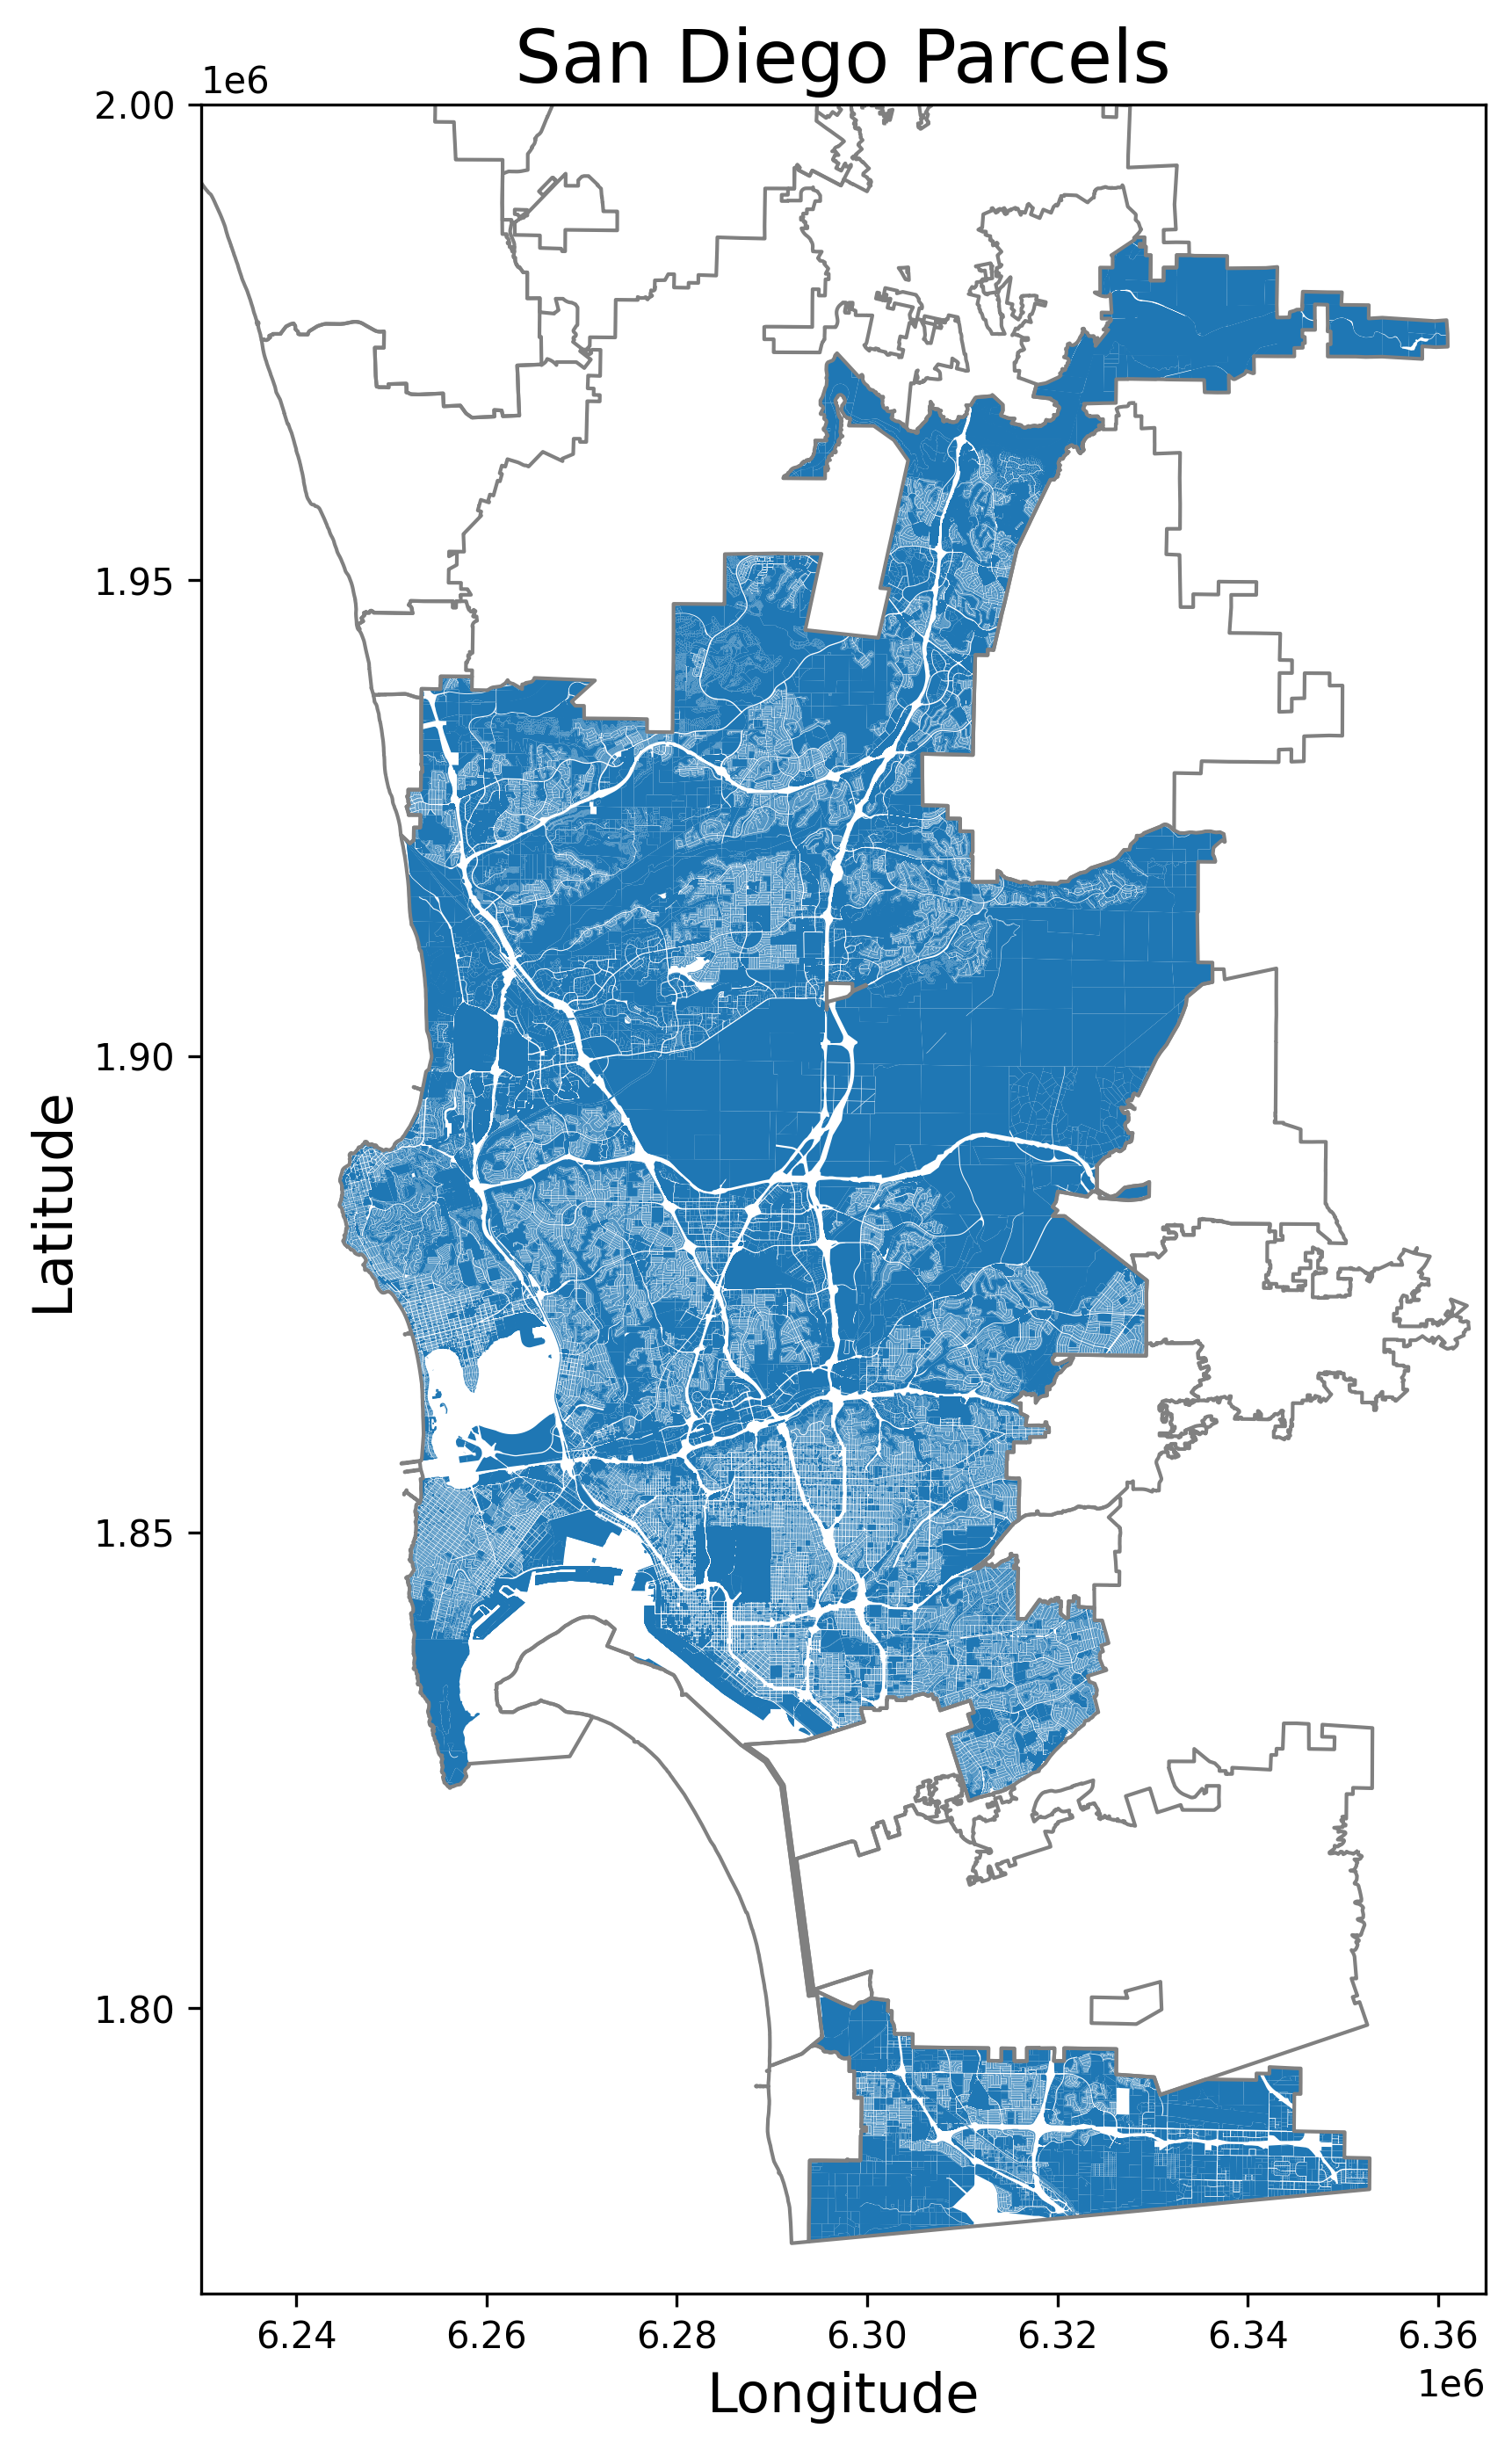

In [122]:
import matplotlib.pyplot as plt

shoreline = gpd.read_file(SHAPEFILES['shoreline']['shapefile']).to_crs(2230)

fig, ax = plt.subplots(figsize = (8.5,11))
parcels.plot(ax=ax)
municipal_boundaries.plot(ax=ax, facecolor=(0, 0, 0, 0), edgecolor=(.5, .5, .5), linewidth=1)
ax.set_title('San Diego Parcels',fontdict = {'fontsize': 20})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 15})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 15})
ax.set_ylim(1.77E6, 2.0E6)
ax.set_xlim(6.23E6, 6.365E6)
fig.set_dpi(300.0)